In [1]:
import fbprophet as fb
import itertools
from fbprophet.diagnostics import cross_validation, performance_metrics
import yfinance as yf
import pandas as pd
from datetime import datetime, timedelta
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)



/Users/darreltrinh/.pyenv/versions/3.9.2/envs/.mjdenv/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


In [27]:
t_str = "dis"

day = 31

In [28]:
# HERE - fixed variables that will require manipulation
ticker = (f"{t_str}").upper()
sec = yf.Ticker(ticker)
earnings = sec.earnings_dates

pred_window = day

earnings = pd.DataFrame(earnings).reset_index()

In [29]:
e = earnings.rename(columns={'Earnings Date': 'ds', 'EPS Estimate':'est_eps', 'Reported EPS':'act_eps','Surprise(%)':'surprise'})
e['ds'] = pd.to_datetime(e['ds'].dt.date).dt.tz_localize(None)

e.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12 entries, 0 to 11
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   ds        12 non-null     datetime64[ns]
 1   est_eps   9 non-null      float64       
 2   act_eps   8 non-null      float64       
 3   surprise  8 non-null      float64       
dtypes: datetime64[ns](1), float64(3)
memory usage: 512.0 bytes


In [30]:
e.head()

,ds,est_eps,act_eps,surprise
0,2024-02-06,NaN,NaN,NaN
1,2023-11-06,NaN,NaN,NaN
2,2023-08-08,NaN,NaN,NaN
3,2023-05-09,1.190,NaN,NaN
4,2023-02-08,0.790,0.990,0.261


In [31]:
#create a dataframe to ingest covid lockdowns to regress against stock price

lockdowns = pd.DataFrame([
    {'holiday': 'lockdown_1', 'ds': '2020-03-21', 'lower_window': 0, 'ds_upper': '2020-06-06'},
    {'holiday': 'lockdown_2', 'ds': '2020-07-09', 'lower_window': 0, 'ds_upper': '2020-10-27'},
    {'holiday': 'lockdown_3', 'ds': '2021-02-13', 'lower_window': 0, 'ds_upper': '2021-02-17'},
    {'holiday': 'lockdown_4', 'ds': '2021-05-28', 'lower_window': 0, 'ds_upper': '2021-06-10'},
])
for t_col in ['ds', 'ds_upper']:
    lockdowns[t_col] = pd.to_datetime(lockdowns[t_col])
lockdowns['upper_window'] = (lockdowns['ds_upper'] - lockdowns['ds']).dt.days
lockdowns


,holiday,ds,lower_window,ds_upper,upper_window
0,lockdown_1,2020-03-21,0,2020-06-06,77
1,lockdown_2,2020-07-09,0,2020-10-27,110
2,lockdown_3,2021-02-13,0,2021-02-17,4
3,lockdown_4,2021-05-28,0,2021-06-10,13


In [32]:
hist_pricing = pd.DataFrame(sec.history(period="36mo")).reset_index()
hist_pricing = hist_pricing[['Date', 'Close', 'Volume', 'Open', 'High', 'Low']]
hist_pricing.rename(columns={'Date': 'ds', 'Close': 'y', 'Volume':'volume', 'Open':'open', 'High':'high', 'Low':'low'}, inplace=True)
hist_pricing['ds'] = pd.to_datetime(hist_pricing['ds']).dt.date 

In [33]:
all_dates = pd.date_range(start=hist_pricing['ds'].min(), end=hist_pricing['ds'].max())
#fdays = pd.date_range(start=all_dates.max(), periods=60, freq='D')

all_dates = pd.Series(all_dates)
#fdays = pd.Series(fdays)

#all_dates = pd.concat([all_dates, fdays])
reindex_date = hist_pricing.set_index('ds')

hist_pricing = reindex_date.reindex(all_dates)

hist_pricing[['y', 'open', 'high', 'low']] = hist_pricing[['y', 'open', 'high', 'low']].bfill()
hist_pricing['volume'] = hist_pricing['volume'].fillna(0)

hist_pricing.reset_index(inplace=True)
hist_pricing.rename(columns={'index':'ds'}, inplace=True)


In [34]:
t = hist_pricing.merge(e, how='left', left_on='ds', right_on='ds', suffixes=['_pricing','_earnings'])
t[['est_eps', 'act_eps', 'surprise']] = t[['est_eps', 'act_eps', 'surprise']].bfill()
t[['est_eps', 'act_eps', 'surprise']] = t[['est_eps', 'act_eps', 'surprise']].fillna(0)

# convert back to og name for rest of notebook
hist_pricing = t
hist_pricing.head()

,ds,y,volume,open,high,low,est_eps,act_eps,surprise
0,2020-02-10,142.590,8162100.000,141.030,142.590,140.460,0.270,0.790,1.894
1,2020-02-11,141.010,10790100.000,142.850,142.990,140.460,0.270,0.790,1.894
2,2020-02-12,141.850,8168200.000,141.340,142.220,140.870,0.270,0.790,1.894
3,2020-02-13,140.900,7543100.000,141.170,141.900,140.820,0.270,0.790,1.894
4,2020-02-14,139.540,9110500.000,141.100,141.280,139.130,0.270,0.790,1.894


In [35]:
from pandas.tseries.holiday import USFederalHolidayCalendar

cal = USFederalHolidayCalendar()
holidays = cal.holidays(start=hist_pricing['ds'].min(), end=hist_pricing['ds'].max())

hist_pricing['trading_day'] = (~hist_pricing['ds'].isin(holidays) & (hist_pricing['ds'].dt.weekday < 5)).astype(int)
hist_pricing.sort_values(by='ds', inplace=True)

hist_pricing.head()

,ds,y,volume,open,high,low,est_eps,act_eps,surprise,trading_day
0,2020-02-10,142.590,8162100.000,141.030,142.590,140.460,0.270,0.790,1.894,1
1,2020-02-11,141.010,10790100.000,142.850,142.990,140.460,0.270,0.790,1.894,1
2,2020-02-12,141.850,8168200.000,141.340,142.220,140.870,0.270,0.790,1.894,1
3,2020-02-13,140.900,7543100.000,141.170,141.900,140.820,0.270,0.790,1.894,1
4,2020-02-14,139.540,9110500.000,141.100,141.280,139.130,0.270,0.790,1.894,1


<AxesSubplot: xlabel='ds'>

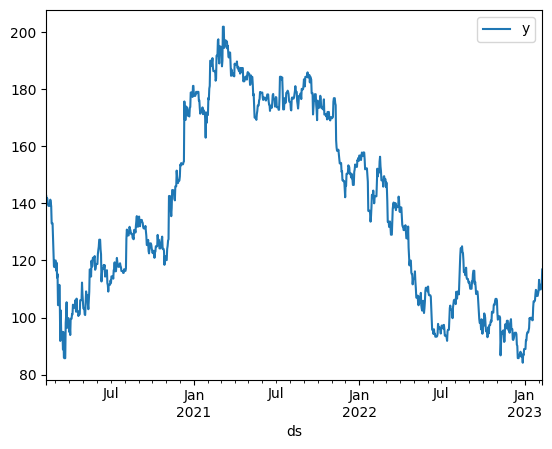

In [36]:
hist_pricing.plot(x='ds', y='y')

In [37]:
hist_pricing['ma20'] = hist_pricing['y'].rolling(window=20).mean()
hist_pricing['ma50'] = hist_pricing['y'].rolling(window=50).mean()
hist_pricing['ma200'] = hist_pricing['y'].rolling(window=200).mean()

hist_pricing['ma20'] = hist_pricing['ma20'].where(hist_pricing['ma20'].notnull(), hist_pricing['y'])
hist_pricing['ma50'] = hist_pricing['ma50'].where(hist_pricing['ma50'].notnull(), hist_pricing['y'])
hist_pricing['ma200'] = hist_pricing['ma200'].where(hist_pricing['ma200'].notnull(), hist_pricing['y'])

hist_pricing.head()

,ds,y,volume,open,high,low,est_eps,act_eps,surprise,trading_day,ma20,ma50,ma200
0,2020-02-10,142.590,8162100.000,141.030,142.590,140.460,0.270,0.790,1.894,1,142.590,142.590,142.590
1,2020-02-11,141.010,10790100.000,142.850,142.990,140.460,0.270,0.790,1.894,1,141.010,141.010,141.010
2,2020-02-12,141.850,8168200.000,141.340,142.220,140.870,0.270,0.790,1.894,1,141.850,141.850,141.850
3,2020-02-13,140.900,7543100.000,141.170,141.900,140.820,0.270,0.790,1.894,1,140.900,140.900,140.900
4,2020-02-14,139.540,9110500.000,141.100,141.280,139.130,0.270,0.790,1.894,1,139.540,139.540,139.540




param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
mapes = []  # Store the MAPEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    m = fb.Prophet(**params, holidays=lockdowns, seasonality_mode='multiplicative', yearly_seasonality=True)  # Fit model with given params
    m.add_country_holidays(country_name='US')
    m.add_regressor('volume')
    m.add_regressor('open')
    m.add_regressor('high')
    m.add_regressor('low')
    m.fit(hist_pricing)
    df_cv = cross_validation(m,  initial='420 days', period='90 days', horizon = '180 days', parallel='processes')
    df_p = performance_metrics(df_cv, rolling_window=1)
    mapes.append(df_p['mape'].values[0])


# separate from cross validation for readability
# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['mape'] = mapes
best_params = all_params[np.argmin(mapes)]
print(best_params)

In [38]:
#, changepoint_prior_scale=best_params['changepoint_prior_scale'], seasonality_prior_scale=best_params['seasonality_prior_scale']
m = fb.Prophet(holidays=lockdowns, seasonality_mode='multiplicative'
                , yearly_seasonality=True
                , daily_seasonality=True 
                #, changepoint_prior_scale=best_params['changepoint_prior_scale'], 
                #seasonality_prior_scale=best_params['seasonality_prior_scale']
                )  # Fit model with given params
m.add_country_holidays(country_name='US')
m.add_regressor('ma20')
m.add_regressor('ma50')
m.add_regressor('ma200')
#m.add_regressor('volume', mode='multiplicative')
m.add_regressor('open', mode='multiplicative')
#m.add_regressor('high', mode='multiplicative')
#m.add_regressor('low', mode='multiplicative')
m.add_regressor('trading_day', mode='multiplicative')
#m.add_regressor('est_eps')
#m.add_regressor('act_eps')
#m.add_regressor('surprise')

m.fit(hist_pricing)

/Users/darreltrinh/.pyenv/versions/3.9.2/envs/.mjdenv/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/darreltrinh/.pyenv/versions/3.9.2/envs/.mjdenv/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -16.1714
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       4490.81    0.00117334       6172.37      0.8262      0.8262      117   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       4527.89    0.00320475       3504.18      0.8885      0.8885      220   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       4534.48   0.000267812       693.117           1           1      328   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       4537.76    0.00617623       670.234      0.9807      0.9807      441   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       4540.81   0.000464096       295.289           1           1      559   
    Iter      log prob        ||dx||      ||grad||       alpha  

  4541.77   7.62709e-05       224.517       0.486       0.486      674   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     699       4542.79   0.000128798       217.851           1           1      790   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     799       4543.52    1.9722e-05       207.678           1           1      914   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     899       4543.64   9.68982e-05       137.579           1           1     1036   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     999       4544.45   0.000499611       148.532      0.3904           1     1155   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1099       4544.81    0.00246184       501.284           1           1     1281   
    Iter      log prob        |

In [39]:
hist_vol = hist_pricing[['ds', 'volume', 'trading_day']]
hist_vol.rename(columns={'volume':'y'}, inplace=True)

volm = fb.Prophet(holidays=lockdowns, seasonality_mode='multiplicative'
                , yearly_seasonality=True 
                #, changepoint_prior_scale=best_params['changepoint_prior_scale'], 
                #seasonality_prior_scale=best_params['seasonality_prior_scale']
                )  # Fit model with given params
volm.add_country_holidays(country_name='US')
volm.add_regressor('trading_day')
volm.fit(hist_vol)

volf = volm.make_future_dataframe(periods = pred_window)
volf['trading_day'] = (~volf['ds'].isin(holidays) & (volf['ds'].dt.weekday < 5)).astype(int)

vol_forecast = volm.predict(volf)
vol = vol_forecast[['ds', 'yhat']]
vol.rename(columns={'yhat':'yvol'}, inplace=True)

/var/folders/_x/rmbn1d5n4cx4ht3tt724nzrc0000gn/T/ipykernel_59856/181172718.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hist_vol.rename(columns={'volume':'y'}, inplace=True)
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -7.83826


/Users/darreltrinh/.pyenv/versions/3.9.2/envs/.mjdenv/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/darreltrinh/.pyenv/versions/3.9.2/envs/.mjdenv/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2369.25     0.0648312         516.8           1           1      132   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       2380.42    0.00383563       194.988      0.6499      0.6499      258   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       2398.49     0.0182689       297.175           1           1      380   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     364       2401.82   4.19546e-05       140.958   2.622e-07       0.001      499  LS failed, Hessian reset 
     399       2402.67    2.4156e-05       79.7274      0.6427      0.6427      547   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       2404.22   6.76832e-05       97.9164      0.4587      0.4587      6

/Users/darreltrinh/.pyenv/versions/3.9.2/envs/.mjdenv/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/darreltrinh/.pyenv/versions/3.9.2/envs/.mjdenv/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/darreltrinh/.pyenv/versions/3.9.2/envs/.mjdenv/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/darreltrinh/.pyenv/versions/3.9.2/envs/.mjdenv/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.app

In [40]:
hist_open = hist_pricing[['ds', 'open','trading_day']]
hist_open.rename(columns={'open':'y'}, inplace=True)

openm = fb.Prophet(holidays=lockdowns, seasonality_mode='multiplicative'
                , yearly_seasonality=True
                , daily_seasonality=True
                #, changepoint_prior_scale=best_params['changepoint_prior_scale'], 
                #seasonality_prior_scale=best_params['seasonality_prior_scale']
                )  # Fit model with given params
openm.add_country_holidays(country_name='US')
openm.add_regressor('trading_day')
openm.fit(hist_open)

openf = openm.make_future_dataframe(periods = pred_window)
openf['trading_day'] = (~openf['ds'].isin(holidays) & (openf['ds'].dt.weekday < 5)).astype(int)

open_forecast = openm.predict(openf)
open = open_forecast[['ds', 'yhat']]
open.rename(columns={'yhat':'yopen'}, inplace=True)

/var/folders/_x/rmbn1d5n4cx4ht3tt724nzrc0000gn/T/ipykernel_59856/3348964769.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hist_open.rename(columns={'open':'y'}, inplace=True)
/Users/darreltrinh/.pyenv/versions/3.9.2/envs/.mjdenv/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/darreltrinh/.pyenv/versions/3.9.2/envs/.mjdenv/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -17.264
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3083.22      0.192317       5009.14           1           1      115   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       3198.95     0.0564095       1751.41       1.347      0.1347      230   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       3246.51    0.00258399       1182.94      0.1277      0.9062      356   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       3339.53    0.00260191       5884.63      0.4778      0.4778      474   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       3368.98    0.00253477       1328.91      0.9692      0.9692      591   
    Iter      log prob        ||dx||      ||grad||       alpha   

/Users/darreltrinh/.pyenv/versions/3.9.2/envs/.mjdenv/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/darreltrinh/.pyenv/versions/3.9.2/envs/.mjdenv/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/darreltrinh/.pyenv/versions/3.9.2/envs/.mjdenv/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/darreltrinh/.pyenv/versions/3.9.2/envs/.mjdenv/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.app

In [41]:
hist_high = hist_pricing[['ds', 'high','trading_day']]
hist_high.rename(columns={'high':'y'}, inplace=True)

highm = fb.Prophet(holidays=lockdowns, seasonality_mode='multiplicative'
                , yearly_seasonality=True
                , daily_seasonality=True 
                #, changepoint_prior_scale=best_params['changepoint_prior_scale'], 
                #seasonality_prior_scale=best_params['seasonality_prior_scale']
                )  # Fit model with given params
highm.add_country_holidays(country_name='US')
highm.add_regressor('trading_day')
highm.fit(hist_high)

highf = highm.make_future_dataframe(periods = pred_window)
highf['trading_day'] = (~highf['ds'].isin(holidays) & (highf['ds'].dt.weekday < 5)).astype(int)

high_forecast = highm.predict(openf)
high = high_forecast[['ds', 'yhat']]
high.rename(columns={'yhat':'yhigh'}, inplace=True)

/var/folders/_x/rmbn1d5n4cx4ht3tt724nzrc0000gn/T/ipykernel_59856/2328955426.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hist_high.rename(columns={'high':'y'}, inplace=True)
/Users/darreltrinh/.pyenv/versions/3.9.2/envs/.mjdenv/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/darreltrinh/.pyenv/versions/3.9.2/envs/.mjdenv/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -16.3699
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3177.33       0.02059       740.279      0.9665      0.9665      109   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       3240.14    0.00888461       488.474      0.2909      0.2909      232   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       3303.11   0.000701773       1465.36      0.2779      0.2779      354   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       3367.91    0.00372374       2449.32           1           1      473   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       3423.86     0.0280891       2633.88           1           1      602   
    Iter      log prob        ||dx||      ||grad||       alpha  

/Users/darreltrinh/.pyenv/versions/3.9.2/envs/.mjdenv/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/darreltrinh/.pyenv/versions/3.9.2/envs/.mjdenv/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/darreltrinh/.pyenv/versions/3.9.2/envs/.mjdenv/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/darreltrinh/.pyenv/versions/3.9.2/envs/.mjdenv/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.app

In [42]:
hist_low = hist_pricing[['ds', 'low', 'trading_day']]
hist_low.rename(columns={'low':'y'}, inplace=True)

lowm = fb.Prophet(holidays=lockdowns, seasonality_mode='multiplicative'
                , yearly_seasonality=True 
                #, changepoint_prior_scale=best_params['changepoint_prior_scale'], 
                #seasonality_prior_scale=best_params['seasonality_prior_scale']
                )  # Fit model with given params
lowm.add_country_holidays(country_name='US')
lowm.add_regressor('trading_day')
lowm.fit(hist_low)

lowf = lowm.make_future_dataframe(periods = pred_window)
lowf['trading_day'] = (~lowf['ds'].isin(holidays) & (lowf['ds'].dt.weekday < 5)).astype(int)

low_forecast = lowm.predict(openf)
low = low_forecast[['ds', 'yhat']]
low.rename(columns={'yhat':'ylow'}, inplace=True)

/var/folders/_x/rmbn1d5n4cx4ht3tt724nzrc0000gn/T/ipykernel_59856/842896148.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hist_low.rename(columns={'low':'y'}, inplace=True)
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/darreltrinh/.pyenv/versions/3.9.2/envs/.mjdenv/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/darreltrinh/.pyenv/versions/3.9.2/envs/.mjdenv/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  

Initial log joint probability = -17.085
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3084.75    0.00310864       167.309           1           1      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       3101.79     0.0484194       279.512           1           1      241   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     293       3107.15   0.000190698       320.556   5.453e-07       0.001      397  LS failed, Hessian reset 
     299       3107.45    0.00500609       591.989      0.3066           1      404   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       3109.12    0.00112612       226.685      0.8849      0.8849      529   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     443       3110.35   0.000560386     

/Users/darreltrinh/.pyenv/versions/3.9.2/envs/.mjdenv/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/darreltrinh/.pyenv/versions/3.9.2/envs/.mjdenv/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/darreltrinh/.pyenv/versions/3.9.2/envs/.mjdenv/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/darreltrinh/.pyenv/versions/3.9.2/envs/.mjdenv/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.app

In [43]:
date2actuals = hist_pricing[['ds', 'y']]
date2actuals.head()

,ds,y
0,2020-02-10,142.590
1,2020-02-11,141.010
2,2020-02-12,141.850
3,2020-02-13,140.900
4,2020-02-14,139.540


/Users/darreltrinh/.pyenv/versions/3.9.2/envs/.mjdenv/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/darreltrinh/.pyenv/versions/3.9.2/envs/.mjdenv/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/darreltrinh/.pyenv/versions/3.9.2/envs/.mjdenv/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/darreltrinh/.pyenv/versions/3.9.2/envs/.mjdenv/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.app

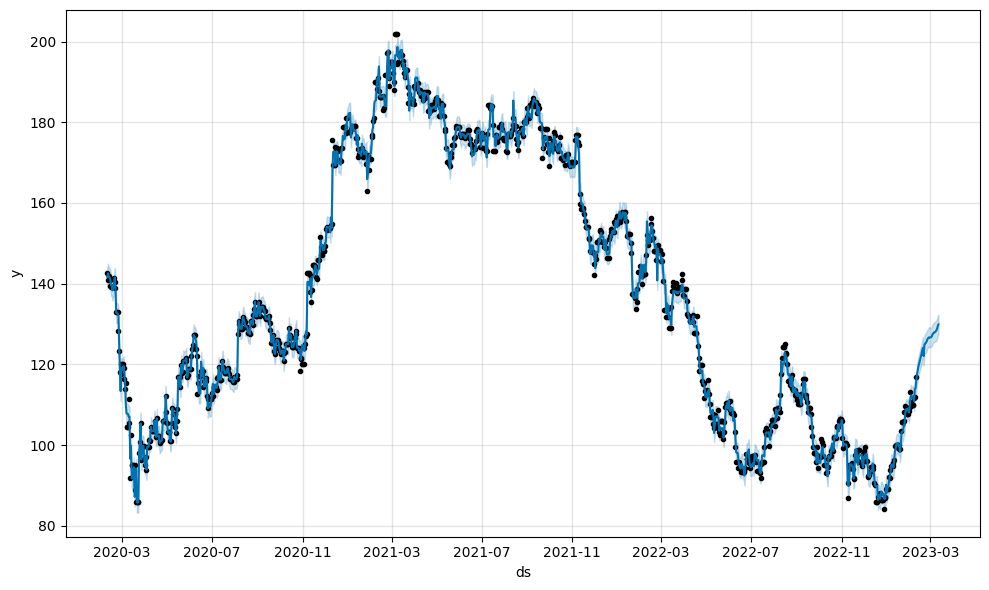

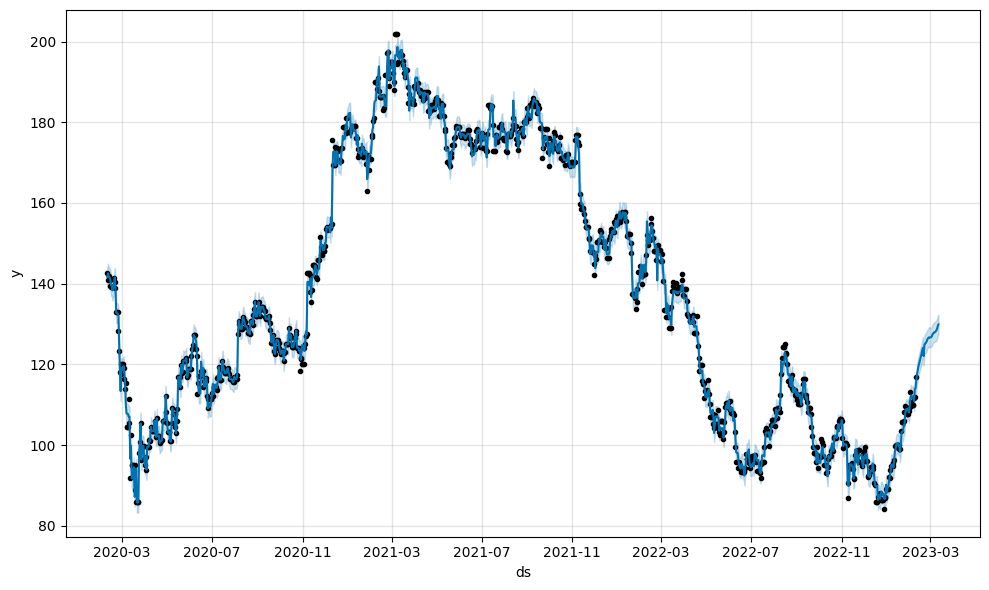

In [44]:
future = m.make_future_dataframe(periods=pred_window, include_history=True)
future['y'] = hist_pricing['y']

future['ma20'] = future['y'].rolling(window=20).mean()
future['ma50'] = future['y'].rolling(window=50).mean()
future['ma200'] = future['y'].rolling(window=200).mean()

future.fillna(method='ffill', inplace=True)

#future['volume'] = hist_pricing['volume']
future['open'] = hist_pricing['open']
#future['high'] = hist_pricing['high']
#future['low'] = hist_pricing['low']

future_merge = future.merge(open, on='ds', how='outer')
#future_merge = future_merge.merge(high, on='ds', how='outer')
#future_merge = future_merge.merge(low, on='ds', how='outer')

#future_merge['volume'] = future_merge['volume'].where(future_merge['volume'].notnull(), future_merge['yvol'])
future_merge['open'] = future_merge['open'].where(future_merge['open'].notnull(), future_merge['yopen'])
#future_merge['high'] = future_merge['high'].where(future_merge['high'].notnull(), future_merge['yhigh'])
#future_merge['low'] = future_merge['low'].where(future_merge['low'].notnull(), future_merge['ylow'])

#future = future_merge.drop(columns=['yvol','yopen','yhigh', 'ylow'])
future = future_merge.drop(columns=['yopen'])

future['trading_day'] = (~future['ds'].isin(holidays) & (future['ds'].dt.weekday < 5)).astype(int)

future['ma20_2'] = future['ma20'].rolling(window=20).mean()
future['ma50_2'] = future['ma50'].rolling(window=50).mean()
future['ma200_2'] = future['ma200'].rolling(window=200).mean()

#future_merge = future.merge(date2actuals, on='ds', how='outer')
future['ma20'] = future['ma20'].where(future['ma20'].notnull(), future['y'])
future['ma50'] = future['ma50'].where(future['ma50'].notnull(), future['y'])
future['ma200'] = future['ma200'].where(future['ma200'].notnull(), future['y'])


#future.drop(columns=['y'], inplace=True)

forecast = m.predict(future)

m.plot(forecast)

In [45]:
df_cv = cross_validation(m,  initial='900 days', period= f'{day} days', horizon = '1 day', parallel='processes')
df_p = performance_metrics(df_cv, rolling_window=1)

INFO:fbprophet:Making 7 forecasts with cutoffs between 2022-08-06 00:00:00 and 2023-02-08 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x167ebc880>
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
/Users/darreltrinh/.pyenv/versions/3.9.2/envs/.mjdenv/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/darreltrinh/.pyenv/versions/3.9.2/envs/.mjdenv/lib/python3.9/site-packages/fbprophet/fore

Initial log joint probability = -22.0563
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       4201.65     0.0131442       5474.56           1           1      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -20.857
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


/Users/darreltrinh/.pyenv/versions/3.9.2/envs/.mjdenv/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/darreltrinh/.pyenv/versions/3.9.2/envs/.mjdenv/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/darreltrinh/.pyenv/versions/3.9.2/envs/.mjdenv/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/darreltrinh/.pyenv/versions/3.9.2/envs/.mjdenv/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.app

Initial log joint probability = -17.7655
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       4264.35   0.000745819       550.156           1           1      230   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -16.7794
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -21.452
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       4351.24    0.00547586        3737.3           1           1      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -18.3362
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3840.38    0.00256767       11951.3     0.08839           1      122   
    Iter      log prob  

/Users/darreltrinh/.pyenv/versions/3.9.2/envs/.mjdenv/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/darreltrinh/.pyenv/versions/3.9.2/envs/.mjdenv/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/darreltrinh/.pyenv/versions/3.9.2/envs/.mjdenv/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/darreltrinh/.pyenv/versions/3.9.2/envs/.mjdenv/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.app

     299       4269.72    0.00186407       1729.48           1           1      339   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -19.9148
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       4470.62    0.00103058       3602.12           1           1      112   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        3994.6     0.0026817          4829      0.4344           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       4392.35   0.000632389       1137.51           1           1      236   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3714.34   0.000334375       1899.55           1           1      116   
    Iter      log prob        ||dx||      ||grad||       alpha  

/Users/darreltrinh/.pyenv/versions/3.9.2/envs/.mjdenv/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/darreltrinh/.pyenv/versions/3.9.2/envs/.mjdenv/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/darreltrinh/.pyenv/versions/3.9.2/envs/.mjdenv/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/darreltrinh/.pyenv/versions/3.9.2/envs/.mjdenv/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.app

     999       3765.02   2.54886e-05       122.034           1           1     1219   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1099       4412.19   8.12759e-07       82.4031      0.4227      0.4227     1237   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1199       4279.98   8.68275e-06       89.7635      0.5128      0.5128     1432   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     999       4540.57   4.15921e-05       395.725      0.4424      0.4424     1126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     999       4152.46   1.46246e-05       108.516      0.8929      0.2009     1149   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1099       4019.94   9.04415e-05       157.921           1           1     1256   
    Iter      log 

/Users/darreltrinh/.pyenv/versions/3.9.2/envs/.mjdenv/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/darreltrinh/.pyenv/versions/3.9.2/envs/.mjdenv/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/darreltrinh/.pyenv/versions/3.9.2/envs/.mjdenv/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/darreltrinh/.pyenv/versions/3.9.2/envs/.mjdenv/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.app

    1299        4412.3    4.5128e-06        89.418           1           1     1468   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1199       4540.95   0.000980322       173.741           1           1     1356   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1199       4152.76   5.56636e-05        135.36           1           1     1386   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1312        4412.3   2.19406e-07       71.0084           1           1     1493   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
    1299       3765.34    0.00196219       188.406           1           1     1625   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1499       4281.51   3.51856e-05        170.83      0.4712      0.4712     1782   
    

/Users/darreltrinh/.pyenv/versions/3.9.2/envs/.mjdenv/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/darreltrinh/.pyenv/versions/3.9.2/envs/.mjdenv/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/darreltrinh/.pyenv/versions/3.9.2/envs/.mjdenv/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/darreltrinh/.pyenv/versions/3.9.2/envs/.mjdenv/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.app

    1299       4152.83   1.18347e-06         87.49      0.4381      0.4381     1545   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1299       4541.32   4.43382e-05       98.0254           1           1     1520   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1599       4281.79   3.81199e-05       114.142           1           1     1911   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1399       3765.47    4.9659e-05       106.311           1           1     1790   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1399       4153.01   2.48563e-05       307.817    0.005878      0.3722     1665   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1499       3765.52   9.76494e-05       209.493           1           1     1901   
    Iter      log 

/Users/darreltrinh/.pyenv/versions/3.9.2/envs/.mjdenv/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/darreltrinh/.pyenv/versions/3.9.2/envs/.mjdenv/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/darreltrinh/.pyenv/versions/3.9.2/envs/.mjdenv/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/darreltrinh/.pyenv/versions/3.9.2/envs/.mjdenv/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.app

    1899          4543   0.000143631       129.192      0.5519      0.5519     2299   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1942       4154.28   3.42504e-05       456.094   3.834e-07       0.001     2412  LS failed, Hessian reset 
    1995       4154.35   2.45676e-06       102.133   1.878e-08       0.001     2514  LS failed, Hessian reset 
    1999       4154.35   3.09491e-05       104.238           1           1     2519   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1999       4543.06   3.84769e-06       123.438      0.2006      0.2006     2427   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    2055       4154.39   2.85736e-05       271.172    2.37e-07       0.001     2631  LS failed, Hessian reset 
    2099       4543.15   2.82462e-06        85.704      0.2155      0.6727     2547   
    Iter      log prob        ||dx||      |

/Users/darreltrinh/.pyenv/versions/3.9.2/envs/.mjdenv/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/darreltrinh/.pyenv/versions/3.9.2/envs/.mjdenv/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/darreltrinh/.pyenv/versions/3.9.2/envs/.mjdenv/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/darreltrinh/.pyenv/versions/3.9.2/envs/.mjdenv/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.app

    2299       4154.56   8.05907e-05       103.406           1           1     2928   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    2399        4154.7   0.000294173        110.06           1           1     3046   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    2499       4154.86   4.23489e-05       205.762           1           1     3181   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    2599       4154.91   3.03489e-05       180.014           1           1     3304   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    2695          4155   3.28782e-06       153.381   2.774e-08       0.001     3458  LS failed, Hessian reset 
    2699          4155   1.92393e-05       145.007      0.6726      0.6726     3462   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  N

/Users/darreltrinh/.pyenv/versions/3.9.2/envs/.mjdenv/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/darreltrinh/.pyenv/versions/3.9.2/envs/.mjdenv/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/darreltrinh/.pyenv/versions/3.9.2/envs/.mjdenv/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/darreltrinh/.pyenv/versions/3.9.2/envs/.mjdenv/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.app

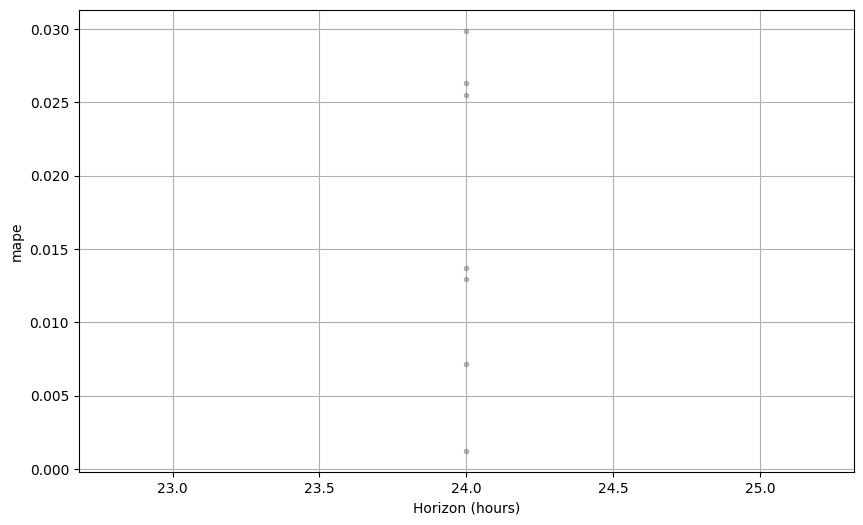

In [46]:
from fbprophet.plot import plot_cross_validation_metric

fig = plot_cross_validation_metric(df_cv, metric='mape')

In [47]:
df_p

,horizon,mse,rmse,mae,mape,mdape,coverage
0,1 days,4.408,2.100,1.767,0.017,0.014,0.571


In [48]:
fc = forecast[['ds', 'yhat']]
fc = fc[fc['ds'] > datetime.today()]
fc

,ds,yhat
1096,2023-02-10,116.106
1097,2023-02-11,117.492
1098,2023-02-12,118.584
1099,2023-02-13,119.593
1100,2023-02-14,120.251
1101,2023-02-15,121.055
1102,2023-02-16,121.731
1103,2023-02-17,122.493
1104,2023-02-18,123.450
1105,2023-02-19,124.086


<AxesSubplot: >

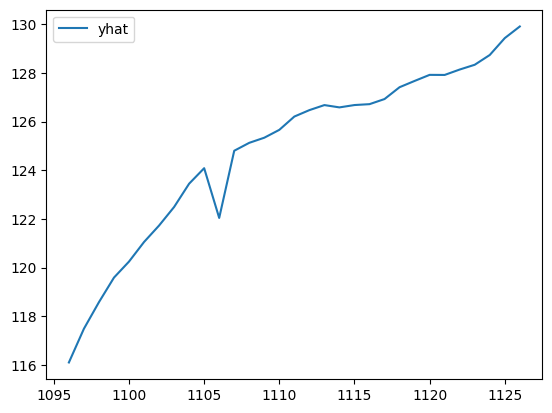

In [49]:
sns.lineplot(data=fc)

/Users/darreltrinh/.pyenv/versions/3.9.2/envs/.mjdenv/lib/python3.9/site-packages/fbprophet/plot.py:422: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(yticklabels)
/Users/darreltrinh/.pyenv/versions/3.9.2/envs/.mjdenv/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/darreltrinh/.pyenv/versions/3.9.2/envs/.mjdenv/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/darreltrinh/.pyenv/versions/3.9.2/envs/.mjdenv/lib/python3.9/site-packages/fbprophet/plot.py:422: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(yticklabels

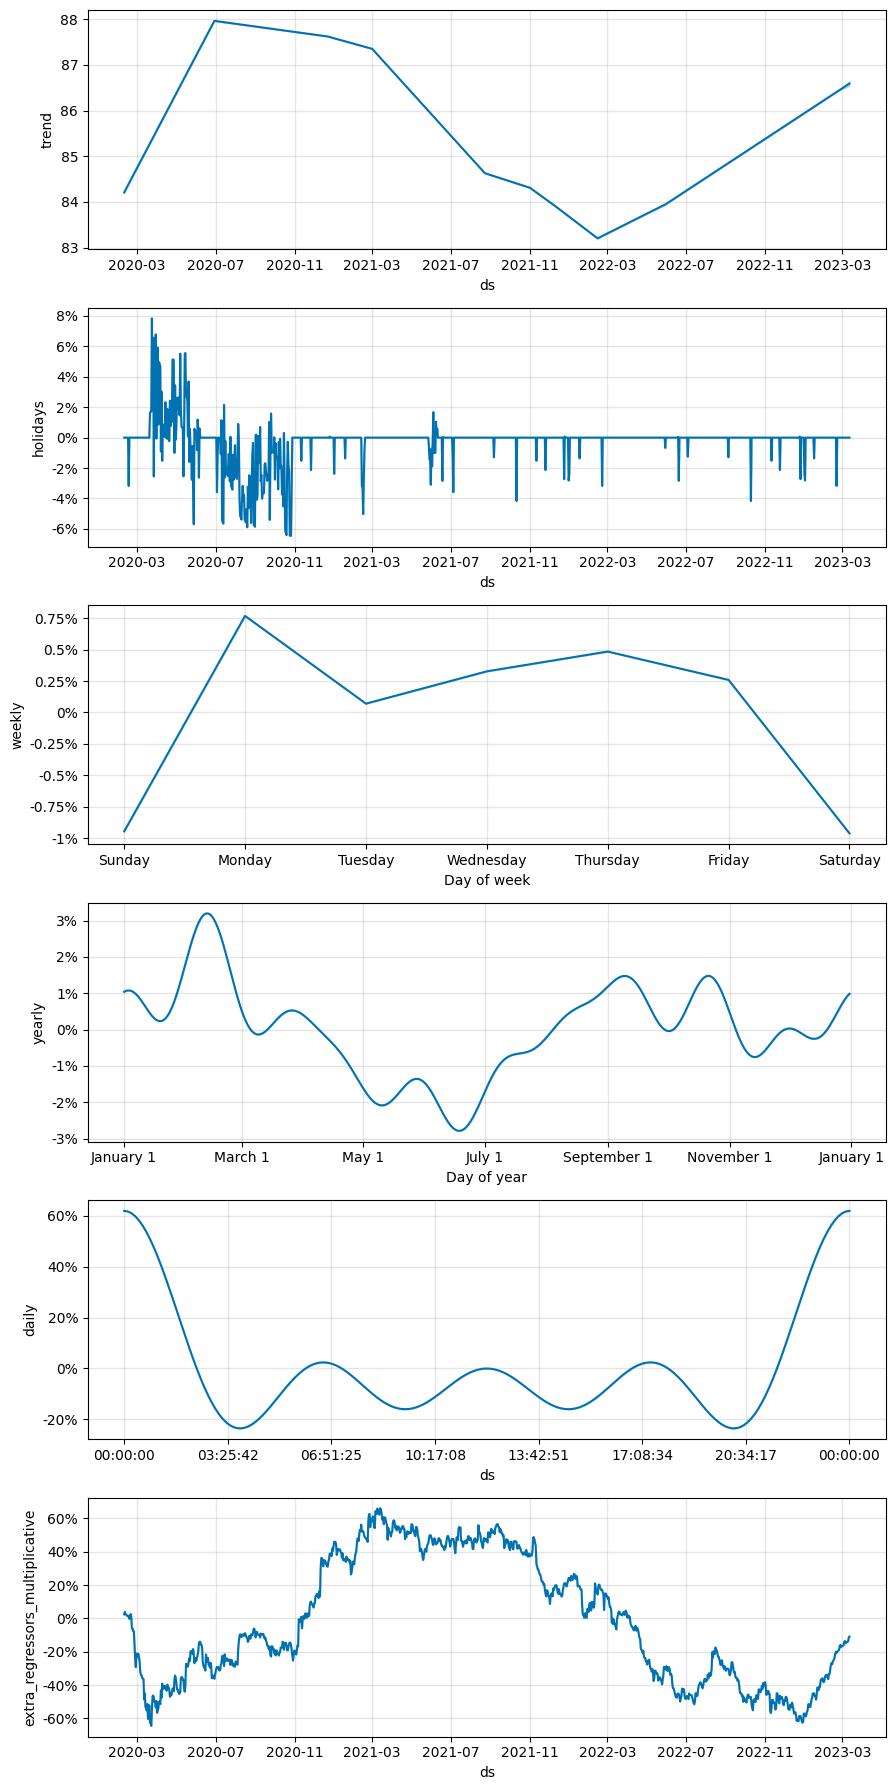

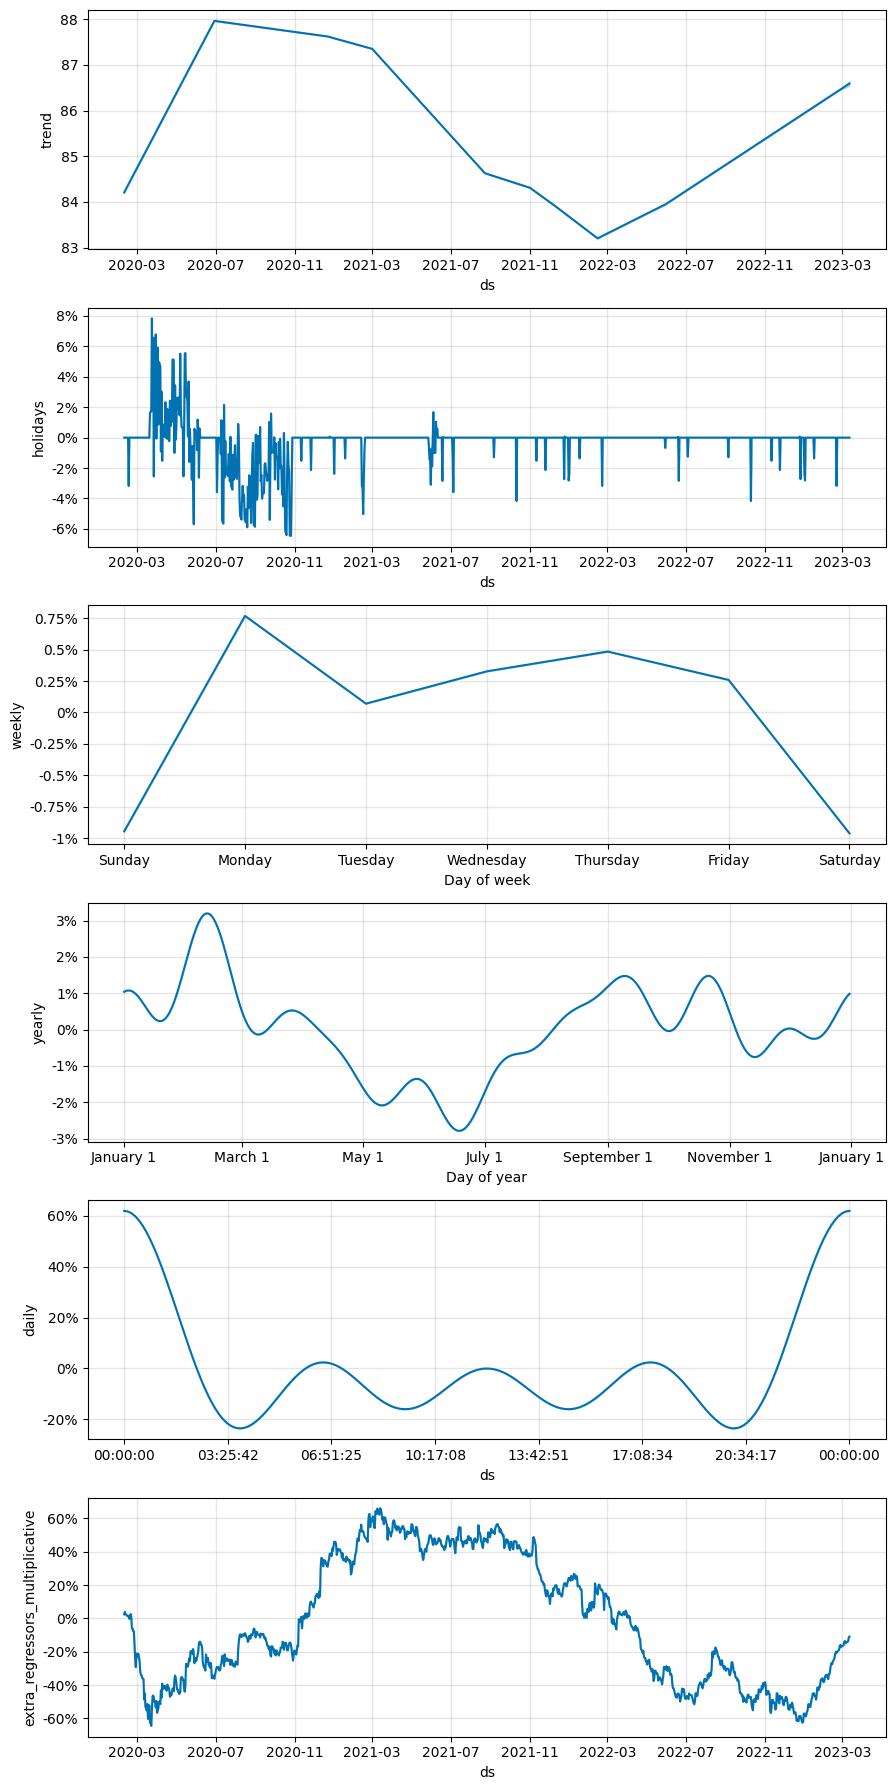

In [50]:
m.plot_components(forecast)

In [51]:
hist_pricing[hist_pricing['ds'].dt.month == 2]

,ds,y,volume,open,high,low,est_eps,act_eps,surprise,trading_day,ma20,ma50,ma200
0,2020-02-10,142.590,8162100.000,141.030,142.590,140.460,0.270,0.790,1.894,1,142.590,142.590,142.590
1,2020-02-11,141.010,10790100.000,142.850,142.990,140.460,0.270,0.790,1.894,1,141.010,141.010,141.010
2,2020-02-12,141.850,8168200.000,141.340,142.220,140.870,0.270,0.790,1.894,1,141.850,141.850,141.850
3,2020-02-13,140.900,7543100.000,141.170,141.900,140.820,0.270,0.790,1.894,1,140.900,140.900,140.900
4,2020-02-14,139.540,9110500.000,141.100,141.280,139.130,0.270,0.790,1.894,1,139.540,139.540,139.540
5,2020-02-15,139.140,0.000,139.020,139.660,138.100,0.270,0.790,1.894,0,139.140,139.140,139.140
6,2020-02-16,139.140,0.000,139.020,139.660,138.100,0.270,0.790,1.894,0,139.140,139.140,139.140
7,2020-02-17,139.140,0.000,139.020,139.660,138.100,0.270,0.790,1.894,0,139.140,139.140,139.140
8,2020-02-18,139.140,8214900.000,139.020,139.660,138.100,0.270,0.790,1.894,1,139.140,139.140,139.140
9,2020-02-19,141.300,7080900.000,139.630,141.870,139.230,0.270,0.790,1.894,1,141.300,141.300,141.300
